In [ ]:
from google.colab import files
uploaded = files.upload()

Saving potential-talents - Aspiring human resources - seeking human resources.csv to potential-talents - Aspiring human resources - seeking human resources.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df=pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

DataFrame 'df' loaded/available. Proceeding with analysis...


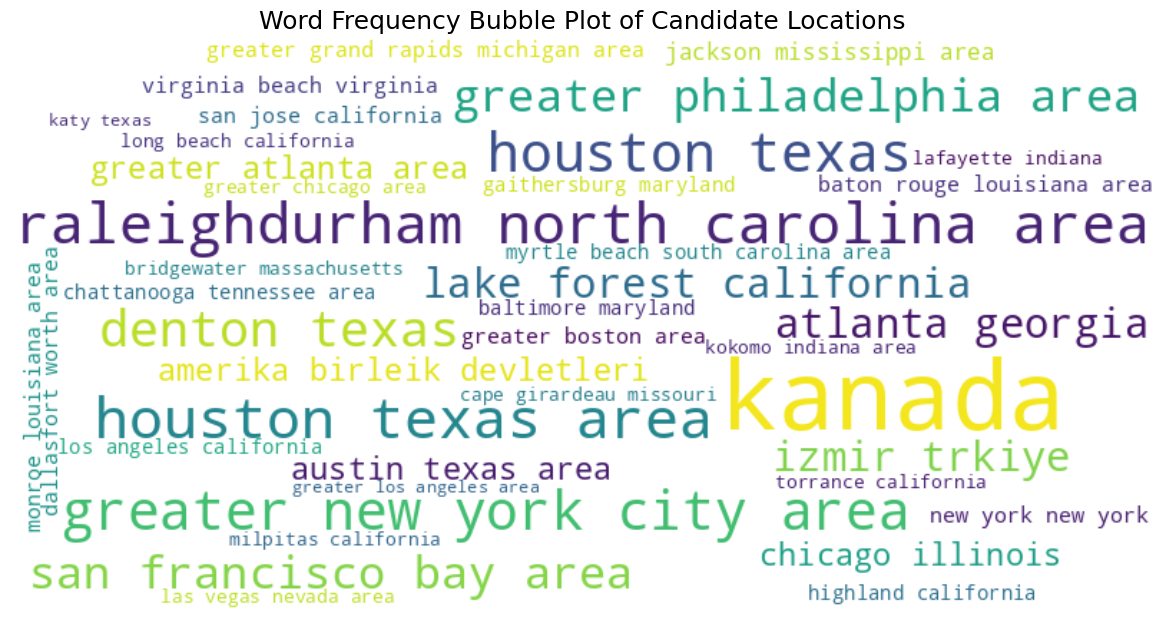

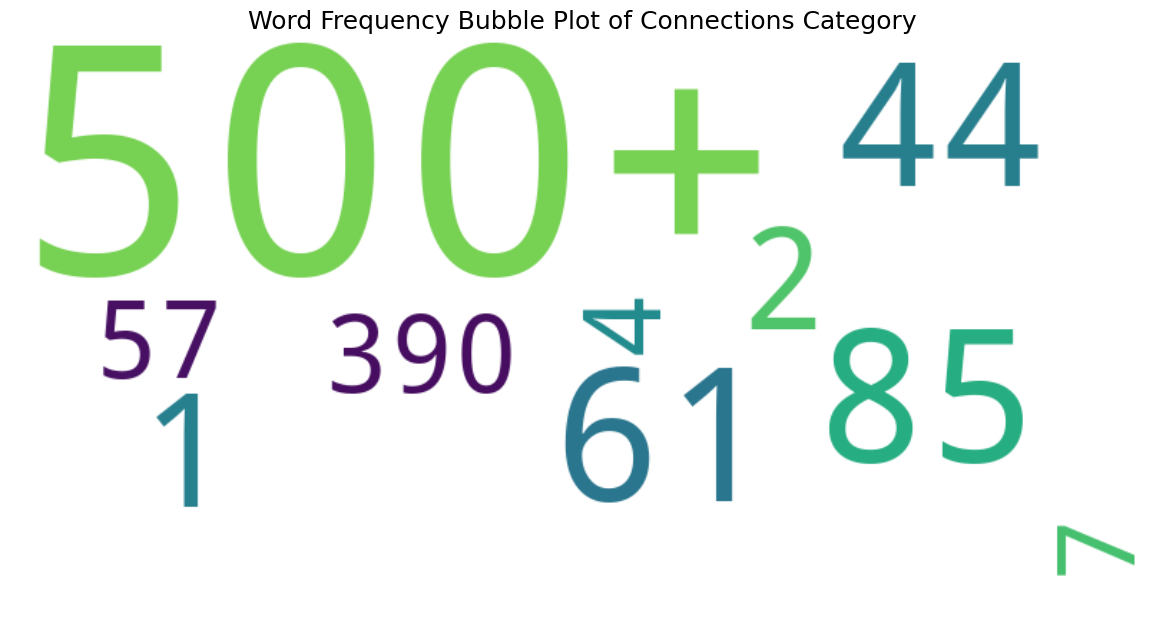

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter


if 'df' in locals():
    print("DataFrame 'df' loaded/available. Proceeding with analysis...")

    # Clean the location data and count frequencies
    # Using str.lower and regex for simple cleaning
    location_data = df['location'].astype(str).str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.strip()
    location_counts = Counter(location_data[location_data != ''])

    # Generate Word Cloud
    loc_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        collocations=False
    ).generate_from_frequencies(location_counts)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(loc_wordcloud, interpolation='bilinear')
    plt.title('Word Frequency Bubble Plot of Candidate Locations', fontsize=18)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show() # Plot 1: Location


    # --- 2. Word Frequency Bubble Plot for CONNECTIONS ---

    connections_data = df['connection'].astype(str).str.lower().str.replace(r'[^a-z0-9\s+]', '', regex=True).str.strip()
    connections_counts = Counter(connections_data[connections_data != ''])

    # Generate Word Cloud
    conn_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=10,
        collocations=False
    ).generate_from_frequencies(connections_counts)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(conn_wordcloud, interpolation='bilinear')
    plt.title('Word Frequency Bubble Plot of Connections Category', fontsize=18)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show() # Plot 2: Connections


    # --- FINAL: Remove unnecessary display lines ---
    # The two plt.show() calls above handle displaying the plots directly.
    # The file saving and Image display lines are not needed here.

else:
    print("ERROR: Please load your data into a pandas DataFrame named 'df' first.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # <--- NEW MODEL
from sklearn.metrics import mean_squared_error, r2_score
import re
import unicodedata
import warnings
warnings.filterwarnings("ignore")


tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    min_df=1,
    stop_words=None,
    token_pattern=r'(?u)\b\w+\b'
)

X = tfidf_vectorizer.fit_transform(df['job_title'])

y = df['fit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
import re
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# 1. TEXT PREPROCESSING
# --------------------------

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["job_title_clean"] = df["job_title"].apply(clean_text)
df["location_clean"] = df["location"].apply(clean_text)

# Extract numeric connections
def parse_connections(val):
    if isinstance(val, str) and "500" in val:
        return 500
    try:
        return int(val)
    except:
        return 0

df["connections_num"] = df["connection"].apply(parse_connections)

# --------------------------
# 2. CREATE TEXT FEATURES
# --------------------------

tfidf_title = TfidfVectorizer(
    max_features=500,
    min_df=1,
    token_pattern=r"(?u)\b\w+\b"
)

tfidf_location = TfidfVectorizer(
    max_features=200,
    min_df=1,
    token_pattern=r"(?u)\b\w+\b"
)

X_title = tfidf_title.fit_transform(df["job_title_clean"])
X_location = tfidf_location.fit_transform(df["location_clean"])

# Combine sparse matrices: title + location + numeric connection count
X = hstack([X_title, X_location, np.array(df["connections_num"]).reshape(-1, 1)])

# --------------------------
# 3. TARGET (fit: probability 0–1)
# --------------------------

y = df["fit"].astype(float)

# --------------------------
# 4. TRAIN-TEST SPLIT
# --------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


ValueError: Input y contains NaN.

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def clean_text(x):
    if pd.isna(x):
        return ""
    x = str(x).lower()
    x = re.sub(r"[^a-z0-9\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df["job_title_clean"] = df["job_title"].apply(clean_text)
df["location_clean"] = df["location"].apply(clean_text)

# ---- 2) connections  ----
def parse_connections(val):
    if pd.isna(val):
        return 0
    s = str(val).strip().lower()
    if "500" in s:
        return 500
    try:
        return int(re.sub(r"[^\d]", "", s)) if re.search(r"\d", s) else 0
    except:
        return 0

df["connections_num"] = df["connection"].apply(parse_connections)

keyword_phrases = [
    "aspiring human resources",
    "seeking human resources"
]

role_prototype = (
    "human resources hr recruiter recruiting talent acquisition "
    "hr assistant hr coordinator people operations"
)

# ---- 4) TF-IDF
corpus = (df["job_title_clean"] + " " + df["location_clean"]).tolist()
tfidf = TfidfVectorizer(max_features=1500, token_pattern=r"(?u)\b\w+\b")
X = tfidf.fit_transform(corpus)

proto_vec = tfidf.transform([role_prototype])
sim = cosine_similarity(X, proto_vec).ravel()  # 0~1 相似度（通常偏小）

def keyword_hit(text):
    t = text.lower()
    return 1.0 if any(k in t for k in keyword_phrases) else 0.0

kw = df["job_title_clean"].apply(keyword_hit).values

# ---- 6) connections ----
conn = df["connections_num"].values.astype(float)
conn_norm = np.log1p(conn) / np.log1p(500)  # 0~1


fit = (
    0.65 * kw +
    0.30 * sim +
    0.05 * conn_norm
)


fit = np.clip(fit, 0, 1)

df["fit_pred"] = fit

df_sorted = df.sort_values("fit_pred", ascending=False)
df_sorted[["id", "job_title", "location", "connection", "fit_pred"]].head(20)


,id,job_title,location,connection,fit_pred
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.709570
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.709570
61,62,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.709570
52,53,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.709570
28,29,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.709336
26,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.709336
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.708890
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.708890
74,75,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",500+,0.705278
93,94,Seeking Human Resources Opportunities. Open t...,Amerika Birleşik Devletleri,415,0.704562


In [ ]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec

def clean_text(x):
    if pd.isna(x):
        return ""
    x = str(x).lower()
    x = re.sub(r"[^a-z0-9\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def tokenize(x):
    x = clean_text(x)
    return x.split() if x else []

def parse_connections(val):
    if pd.isna(val):
        return 0
    s = str(val).strip().lower()
    if "500" in s:
        return 500
    m = re.findall(r"\d+", s)
    return int(m[0]) if m else 0

def avg_w2v(tokens, wv):
    vecs = [wv[t] for t in tokens if t in wv]
    if not vecs:
        return None
    return np.mean(vecs, axis=0)

def cosine(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


df["job_title_clean"] = df["job_title"].apply(clean_text)
df["location_clean"] = df["location"].apply(clean_text)
df["connections_num"] = df["connection"].apply(parse_connections)

In [ ]:
texts = (df["job_title_clean"] + " " + df["location_clean"]).tolist()
sentences = [tokenize(t) for t in texts]

w2v = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    epochs=20,
    seed=42
)
wv = w2v.wv

In [ ]:
keyword_phrases = [
    "aspiring human resources",
    "seeking human resources"
]

role_prototype = (
    "human resources hr recruiter recruiting talent acquisition "
    "hr assistant hr coordinator people operations"
)
proto_tokens = tokenize(role_prototype)
proto_vec = avg_w2v(proto_tokens, wv)

if proto_vec is None:
    proto_vec = np.zeros(wv.vector_size, dtype=float)

def keyword_hit(text):
    t = text.lower()
    return 1.0 if any(k in t for k in keyword_phrases) else 0.0

# --------------------------
# Score each candidate -> fit_pred in [0,1]
# --------------------------
kw = df["job_title_clean"].apply(keyword_hit).values.astype(float)

conn = df["connections_num"].values.astype(float)
conn_norm = np.log1p(conn) / np.log1p(500)  # 0~1

sims = []
for t in texts:
    v = avg_w2v(tokenize(t), wv)
    if v is None:
        sims.append(0.0)
    else:
        sims.append(cosine(v, proto_vec))
sims = np.array(sims, dtype=float)

sim01 = (sims + 1.0) / 2.0
sim01 = np.clip(sim01, 0.0, 1.0)

fit_pred = (
    0.65 * kw +
    0.30 * sim01 +
    0.05 * conn_norm
)
fit_pred = np.clip(fit_pred, 0.0, 1.0)

df["fit_pred"] = fit_pred

# --------------------------
# Top candidates
# --------------------------
df_sorted = df.sort_values("fit_pred", ascending=False)
df_sorted[["id", "job_title", "location", "connection", "fit_pred"]].head(20)

,id,job_title,location,connection,fit_pred
74,75,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",500+,0.999912
26,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.999908
28,29,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.999908
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.999890
52,53,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.999890
61,62,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.999890
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.999890
93,94,Seeking Human Resources Opportunities. Open t...,Amerika Birleşik Devletleri,415,0.998411
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.997892
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.997892


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['fit_pred'].plot(kind='hist', bins=20, title='fit_pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('connection').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='id', y='fit_pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['fit_pred'].plot(kind='line', figsize=(8, 4), title='fit_pred')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['connection'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='id', y='connection', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['connection'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='fit_pred', y='connection', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
import numpy as np
import pandas as pd
import re
import gensim.downloader as api

# Load pre-trained GloVe embeddings (100-dimensional vectors trained on Wikipedia + Gigaword)
# These vectors capture semantic relationships between words based on co-occurrence statistics
kv = api.load("glove-wiki-gigaword-100")

# Lowercase and extract alphanumeric tokens from a text field
# Returns empty list for NaN values to prevent downstream errors
def tokenize(x):
    if pd.isna(x):
        return []
    return re.findall(r"[a-z0-9]+", str(x).lower())

# Normalize LinkedIn-style connection counts to a plain integer
# Handles "500+" edge case and falls back to 0 for unparseable values
def parse_connections(val):
    if pd.isna(val):
        return 0
    s = str(val).strip().lower()
    if "500" in s and "+" in s:
        return 500
    nums = re.findall(r"\d+", s)
    return int(nums[0]) if nums else 0

# Compute the centroid (average) of GloVe vectors for a list of tokens
# Words not found in the vocabulary are silently skipped
# Returns None if no tokens have embeddings (e.g., all unknown words)
def avg_emb(tokens, kv):
    vecs = [kv[w] for w in tokens if w in kv]
    if not vecs:
        return None
    return np.mean(vecs, axis=0)

# Cosine similarity between two vectors; returns 0 if either vector is zero-norm
# Used to measure semantic closeness between a candidate's text and the HR role prototype
def cosine(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

# Exact phrases that are strong positive signals for HR role intent
# These trigger a binary keyword boost in the final scoring formula
keyword_phrases = [
    "aspiring human resources",
    "seeking human resources"
]

# Define an HR role prototype as a bag of semantically relevant keywords
# The average embedding of these terms serves as the "ideal candidate" vector in semantic space
role_prototype = (
    "human resources hr recruiter recruiting talent acquisition "
    "hr assistant hr coordinator people operations"
)
proto_vec = avg_emb(tokenize(role_prototype), kv)
# Fallback to zero vector if none of the prototype words exist in the GloVe vocabulary
if proto_vec is None:
    proto_vec = np.zeros(kv.vector_size, dtype=float)

# Binary feature: returns 1.0 if the job title contains a strong HR keyword phrase, else 0.0
# Acts as a hard boost to ensure explicitly HR-targeted candidates rank at the top
def keyword_hit(job_title):
    t = "" if pd.isna(job_title) else str(job_title).lower()
    return 1.0 if any(k in t for k in keyword_phrases) else 0.0

# Concatenate job title and location into a single text field for semantic embedding
# Location context can help disambiguate roles (e.g., regional HR vs. remote)
texts = (df["job_title"].fillna("").astype(str) + " " + df["location"].fillna("").astype(str)).tolist()

# Compute binary keyword hit scores for all candidates
kw = df["job_title"].apply(keyword_hit).values.astype(float)

# Parse and log-normalize connection counts to [0, 1] range
# log1p smooths the skewed distribution; 500 is used as the normalization ceiling
conn = df["connections"].apply(parse_connections).values.astype(float)
conn_norm = np.log1p(conn) / np.log1p(500)

# Compute cosine similarity between each candidate's embedding and the HR prototype vector
sims = []
for t in texts:
    v = avg_emb(tokenize(t), kv)
    sims.append(cosine(v, proto_vec) if v is not None else 0.0)
sims = np.array(sims, dtype=float)

# Rescale cosine similarity from [-1, 1] to [0, 1] for use in the weighted scoring formula
sim01 = np.clip((sims + 1.0) / 2.0, 0.0, 1.0)

# Final weighted scoring formula combining three signals:
#   65% keyword match  — strongest signal; explicit HR intent in job title
#   30% semantic sim   — softer signal; embedding-based relevance to HR role prototype
#    5% connections    — weak social proof; more connections may indicate active networking
df["fit_pred"] = np.clip(
    0.65 * kw + 0.30 * sim01 + 0.05 * conn_norm,
    0.0,
    1.0
)

# Display top 20 candidates ranked by predicted HR fit score in descending order
df.sort_values("fit_pred", ascending=False)[["id", "job_title", "location", "connections", "fit_pred"]].head(20)

,id,job_title,location,connection,fit_pred
26,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.969616
28,29,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.969616
74,75,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",500+,0.967137
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.962528
52,53,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.962528
61,62,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.962528
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.962528
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.953846
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.953846
81,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,0.934197


In [ ]:
import pandas as pd
import numpy as np
import re
import gensim.downloader as api

kv = api.load("fasttext-wiki-news-subwords-300")


def tokenize(x):
    if pd.isna(x):
        return []
    return re.findall(r"[a-z0-9]+", str(x).lower())

def parse_connections(val):
    if pd.isna(val):
        return 0
    s = str(val).strip().lower()

    if "500" in s and "+" in s:
        return 500
    nums = re.findall(r"\d+", s)

    return int(nums[0]) if nums else 0

def avg_emb(tokens, kv):
    vecs = []
    for w in tokens:
        try:
            vecs.append(kv[w])
        except KeyError:
            # For some keyedvector wrappers, OOV may still KeyError
            continue

    if not vecs:
        return None
    return np.mean(vecs, axis=0)

def cosine(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

keyword_phrases = [
    "aspiring human resources",
    "seeking human resources"
]

role_prototype = (
    "human resources hr recruiter recruiting talent acquisition "
    "hr assistant hr coordinator people operations"
)

proto_vec = avg_emb(tokenize(role_prototype), kv)
if proto_vec is None:
    proto_vec = np.zeros(kv.vector_size, dtype=float)

def keyword_hit(job_title):
    t = "" if pd.isna(job_title) else str(job_title).lower()
    return 1.0 if any(k in t for k in keyword_phrases) else 0.0


texts = (df["job_title"].fillna("").astype(str) + " " + df["location"].fillna("").astype(str)).tolist()

kw = df["job_title"].apply(keyword_hit).values.astype(float)

conn = df["connection"].apply(parse_connections).values.astype(float)
conn_norm = np.log1p(conn) / np.log1p(500)  # 0~1

sims = []
for t in texts:
    v = avg_emb(tokenize(t), kv)
    sims.append(cosine(v, proto_vec) if v is not None else 0.0)
sims = np.array(sims, dtype=float)

# cosine [-1,1] -> [0,1]
sim01 = np.clip((sims + 1.0) / 2.0, 0.0, 1.0)

# Weighted fusion
df["fit_pred"] = np.clip(
    0.65 * kw +
    0.30 * sim01 +
    0.05 * conn_norm,
    0.0, 1.0
)

# output
df.sort_values("fit_pred", ascending=False)[["id", "job_title", "location", "connection", "fit_pred"]].head(20)

,id,job_title,location,connection,fit_pred
74,75,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",500+,0.944694
26,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.944560
28,29,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.944560
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.942872
52,53,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.942872
61,62,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.942872
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.942872
81,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,0.937022
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.936102
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.936102


In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 64.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel

# =========================
# 1) Load BERT (contextual embeddings)
# =========================
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda")
model.to(device)

# =========================
# 2) helpers
# =========================
def parse_connections(val):
    if pd.isna(val):
        return 0
    s = str(val).strip().lower()
    if "500" in s and "+" in s:
        return 500
    nums = re.findall(r"\d+", s)
    return int(nums[0]) if nums else 0

keyword_phrases = [
    "aspiring human resources",
    "seeking human resources"
]

def keyword_hit(job_title):
    t = "" if pd.isna(job_title) else str(job_title).lower()
    return 1.0 if any(k in t for k in keyword_phrases) else 0.0

def mean_pooling(model_output, attention_mask):
    token_embeddings=model_output.last_hidden_state  # [B, T, H]
    mask=attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed=torch.sum(token_embeddings * mask, dim=1)
    counts=torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed/counts

@torch.no_grad()
def encode_texts(texts, batch_size=64, max_length=64):
    vecs=[]
    for i in range(0, len(texts), batch_size):
        batch=texts[i:i+batch_size]
        enc=tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        enc={k: v.to(device) for k, v in enc.items()}
        out=model(**enc)
        emb=mean_pooling(out, enc["attention_mask"])
        emb=torch.nn.functional.normalize(emb, p=2, dim=1)
        vecs.append(emb.cpu().numpy())
    return np.vstack(vecs)

# =========================
# 3) Build candidate texts and prototype
# =========================
texts = (df["job_title"].fillna("").astype(str) + " " + df["location"].fillna("").astype(str)).tolist()

role_prototype = (
    "human resources hr recruiter recruiting talent acquisition "
    "hr assistant hr coordinator people operations"
)

# Encode candidate + prototype
X = encode_texts(texts, batch_size=64, max_length=64)                 # [N, H]
P = encode_texts([role_prototype], batch_size=1, max_length=64)[0]    # [H]

# =========================
# 4) Similarity + keyword + connections -> fit_pred in [0,1]
# =========================
# Cosine similarity since embeddings are L2-normalized => dot product in [-1,1]
sims = X @ P  # [N]

# Map [-1,1] -> [0,1]
sim01 = np.clip((sims + 1.0) / 2.0, 0.0, 1.0)

kw = df["job_title"].apply(keyword_hit).values.astype(float)

conn = df["connection"].apply(parse_connections).values.astype(float)
conn_norm = np.log1p(conn) / np.log1p(500)

df["fit_pred"] = np.clip(
    0.65 * kw +
    0.30 * sim01 +
    0.05 * conn_norm,
    0.0, 1.0
)

# Top candidates
df.sort_values("fit_pred", ascending=False)[["id", "job_title", "location", "connection", "fit_pred"]].head(20)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

,id,job_title,location,connection,fit_pred
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.932070
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.932070
61,62,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.932070
52,53,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.932070
28,29,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.926577
26,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,0.926577
81,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,0.925357
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,0.924552
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.918841
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.918841


In [ ]:
# Colab / PyTorch 2.9.0+cu126, CUDA available (Tesla T4)
# Task: Use Qwen/Qwen3-4B-Instruct-2507 to predict fit_pred (0~1) from df: [id, job_title, location, connections]
# Output: df["fit_pred"]

import re
import json
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# ----------------------------
# 1) Load Qwen3-4B Instruct
# ----------------------------
MODEL_ID = "Qwen/Qwen3-4B-Instruct-2507"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
model.eval()

# ----------------------------
# 2) Prompt
# ----------------------------
SYSTEM_PROMPT = (
    "You are an HR screening model. "
    "Given a candidate's job_title, location, and connections, output a single JSON object only: "
    "{\"fit\": <number between 0 and 1>} . "
    "Higher fit if job_title indicates Human Resources intent, especially phrases like "
    "\"Aspiring human resources\" or \"seeking human resources\". "
    "Do not output any extra text."
)

def parse_connections(val):
    if pd.isna(val):
        return "0"
    s = str(val).strip()
    if "500" in s and "+" in s:
        return "500+"
    return s

def build_user_prompt(row):
    return (
        "Return JSON only.\n"
        f"job_title: {'' if pd.isna(row.get('job_title')) else str(row.get('job_title'))}\n"
        f"location: {'' if pd.isna(row.get('location')) else str(row.get('location'))}\n"
        f"connection: {parse_connections(row.get('connection'))}\n"
    )

# ----------------------------
# 3) Generation + robust JSON extraction
# ----------------------------
JSON_RE = re.compile(r"\{[^{}]*\}")

@torch.no_grad()
def predict_fit_one(row, max_new_tokens=32):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": build_user_prompt(row)},
    ]

    # Qwen chat template
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(text, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=0.0,
        top_p=1.0,
        eos_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()

    # Try direct JSON
    try:
        obj = json.loads(gen)
        fit = float(obj.get("fit", 0.0))
        return float(np.clip(fit, 0.0, 1.0))
    except Exception:
        pass

    # Fallback: extract first {...}
    m = JSON_RE.search(gen)
    if m:
        try:
            obj = json.loads(m.group(0))
            fit = float(obj.get("fit", 0.0))
            return float(np.clip(fit, 0.0, 1.0))
        except Exception:
            return 0.0

    return 0.0

# ----------------------------
# 4) Batch loop
# ----------------------------
fits = []
for _, row in df.iterrows():
    fits.append(predict_fit_one(row))

df["fit_pred"] = fits

# output
df.sort_values("fit_pred", ascending=False)[["id", "job_title", "location", "connection", "fit_pred"]].head(20)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


,id,job_title,location,connection,fit_pred
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
23,24,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
76,77,Human Resources|\nConflict Management|\nPolici...,Dallas/Fort Worth Area,409,1.00
59,60,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
70,71,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,1.00
68,69,"Director of Human Resources North America, Gro...","Greater Grand Rapids, Michigan Area",500+,1.00
48,49,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
73,74,Human Resources Professional,Greater Boston Area,16,1.00
74,75,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",500+,1.00


In [ ]:
# Colab / PyTorch, CUDA available (Tesla T4)
# Task: Use a lightweight Llama Instruct model to predict fit_pred (0~1)
# Input df columns: [id, job_title, location, connections]
# Output: df["fit_pred"]

import re
import json
import numpy as np
import pandas as pd
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# ----------------------------
# 0) Install deps (Colab)
# ----------------------------
# If already installed, you can skip.
# !pip -q install -U transformers accelerate bitsandbytes

# ----------------------------
# 1) Load Llama (lightweight via 4-bit)
# ----------------------------
# Good default for quality/size on T4 with 4-bit:
MODEL_ID = "meta-llama/Meta-Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto"
)
model.eval()

# ----------------------------
# 2) Prompt
# ----------------------------
SYSTEM_PROMPT = (
    "You are an HR screening model. "
    "Given a candidate's job_title, location, and connections, output a single JSON object only: "
    "{\"fit\": <number between 0 and 1>} . "
    "Higher fit if job_title indicates Human Resources intent, especially phrases like "
    "\"Aspiring human resources\" or \"seeking human resources\". "
    "Do not output any extra text."
)

def parse_connections(val):
    if pd.isna(val):
        return "0"
    s = str(val).strip()
    if "500" in s and "+" in s:
        return "500+"
    return s

def build_user_prompt(row):
    return (
        "Return JSON only.\n"
        f"job_title: {'' if pd.isna(row.get('job_title')) else str(row.get('job_title'))}\n"
        f"location: {'' if pd.isna(row.get('location')) else str(row.get('location'))}\n"
        f"connection: {parse_connections(row.get('connection'))}\n"
    )

# ----------------------------
# 3) Generation + robust JSON extraction
# ----------------------------
JSON_RE = re.compile(r"\{[^{}]*\}")

@torch.no_grad()
def predict_fit_one(row, max_new_tokens=32):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": build_user_prompt(row)},
    ]

    # Llama chat template
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(text, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=0.0,
        top_p=1.0,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id   # <- add this
    )

    gen = tokenizer.decode(
        out[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    # Try direct JSON
    try:
        obj = json.loads(gen)
        fit = float(obj.get("fit", 0.0))
        return float(np.clip(fit, 0.0, 1.0))
    except Exception:
        pass

    # Fallback: extract first {...}
    m = JSON_RE.search(gen)
    if m:
        try:
            obj = json.loads(m.group(0))
            fit = float(obj.get("fit", 0.0))
            return float(np.clip(fit, 0.0, 1.0))
        except Exception:
            return 0.0

    return 0.0

# ----------------------------
# 4) Batch loop
# ----------------------------
fits = []
for _, row in df.iterrows():
    fits.append(predict_fit_one(row))

df["fit_pred"] = fits

df.sort_values("fit_pred", ascending=False)[["id", "job_title", "location", "connection", "fit_pred"]].head(20)


,id,job_title,location,connection,fit_pred
76,77,Human Resources|\nConflict Management|\nPolici...,Dallas/Fort Worth Area,409,1.0
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.9
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,0.9
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.9
12,13,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,0.9
13,14,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.9
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.9
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,0.9
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,0.9
36,37,Student at Humber College and Aspiring Human R...,Kanada,61,0.9


In [ ]:
import os
os.environ["XAI_API_KEY"] = "xai-232WS83xSg8y4g35aqVX0oP7WD8ep64Lrg5mP6gUpRvjpfpXCHk2S4w9f9vHa1dCDTt4UDC7weG4nRhU"   # Grok API Key

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key=os.environ["XAI_API_KEY"],
    base_url="https://api.x.ai/v1"
)

MODEL = "grok-3-mini"

In [ ]:
SYSTEM_PROMPT = (
    "You are an HR screening model. "
    "Given a candidate's job_title, location, and connections, output a single JSON object only: "
    "{\"fit\": <number between 0 and 1>} . "
    "Higher fit if job_title indicates 1) Human Resources intent, 2) phrases like "
    "\"Aspiring human resources\" or \"seeking human resources\". "
    "Do not output any extra text."
)

In [ ]:
def get_message_text(message):
    if message is None:
        return ""
    content = message.content
    if isinstance(content, str):
        return content
    if isinstance(content, list):
        return "".join(
            block.get("text", "")
            for block in content
            if isinstance(block, dict)
        )
    return ""


In [ ]:
def extract_fit(text: str) -> float:
    if not text:
        return 0.0

    text = re.sub(r"```json|```", "", text, flags=re.IGNORECASE).strip()

    try:
        obj = json.loads(text)
    except Exception:
        m = re.search(r"\{[\s\S]*?\}", text)
        if not m:
            return 0.0
        try:
            obj = json.loads(m.group(0))
        except Exception:
            return 0.0

    fit = obj.get("fit", 0.0)

    try:
        fit = float(fit)
    except Exception:
        return 0.0

    if not np.isfinite(fit):
        return 0.0

    return float(np.clip(fit, 0.0, 1.0))


In [ ]:
def predict_fit_one(pos_row, max_retries=3):
    # Unpack the enumerated tuple: pos is the row index, row is the candidate data dict
    pos, row = pos_row

    # Build the chat message list: system prompt sets the scoring behavior,
    # user prompt provides the candidate's structured fields for evaluation
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": (
                "Return JSON only.\n"
                f"job_title: {row.get('job_title','')}\n"
                f"location: {row.get('location','')}\n"
                f"connection: {row.get('connection','')}\n"
            )
        }
    ]

    # Retry loop: handles transient API failures (rate limits, timeouts, network errors)
    # with incremental backoff to avoid hammering the endpoint on repeated failures
    for attempt in range(max_retries):
        try:
            # Call the LLM API with greedy decoding (temperature=0) for deterministic output
            # max_tokens=64 is sufficient since the expected response is a short JSON object
            resp = client.chat.completions.create(
                model=MODEL,
                messages=messages,
                temperature=0.0,
                max_tokens=64,
            )

            # Extract the raw text content from the first (and only) response choice
            content = get_message_text(resp.choices[0].message)

            # Debug logging for the first 3 candidates to verify raw model output during development
            if pos < 3:
                print(f"[{pos}] RAW:", repr(content))

            # Parse the JSON response and extract the numeric "fit" value
            fit = extract_fit(content)

            # Log the parsed fit score for the first 3 candidates to confirm correct extraction
            if pos < 3:
                print(f"[{pos}] PARSED:", fit)

            # Sanitize the parsed value: treat None or non-finite floats (NaN, inf) as zero
            if fit is None or not np.isfinite(fit):
                fit = 0.0

            return pos, float(fit)

        except Exception as e:
            # Log API or parsing exceptions for the first 3 rows to aid debugging
            if pos < 3:
                print(f"[{pos}] ERROR:", e)
            # Exponential-style backoff: wait longer after each failed attempt (0.5s, 1.0s, 1.5s)
            time.sleep(0.5 * (attempt + 1))

    # All retries exhausted: return 0.0 as a safe default to keep the pipeline moving
    return pos, 0.0


In [ ]:
df.sort_values("fit_pred", ascending=False)[["id", "job_title", "location", "connection", "fit_pred"]].head(60)



,id,job_title,location,connection,fit_pred
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,1.00
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,1.00
14,15,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,1.00
12,13,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,1.00
11,12,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,1.00
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,1.00
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,1.00
32,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,1.00
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,1.00
